In [1]:
import numpy as np
import json 
from PIL import Image
import os
from tqdm import tqdm as tqdm

In [2]:
base_dir = 'out/hammer_validate/'
with open(base_dir + 'face_preds.json') as f:
    face_class = json.load(f)
face_num = len(face_class)
print(face_num)

8534


In [3]:
all_classes = []
for i in face_class:
    if i not in all_classes and i!= 'unknown':
        all_classes.append(i)
print(all_classes)

['head', 'handle']


In [6]:
mask_table = np.zeros((face_num, len(all_classes)))
# class_id = {}
# for idx, class_name in enumerate(all_classes):
#     class_id[class_name] = idx
# for idx, classes in enumerate(face_class):
#     mask_table[idx][class_id[classes]] += 1

In [7]:
def IoU(mask1, mask2):
    union = np.logical_or(mask1, mask2)
    intersection = np.logical_and(mask1, mask2)
    
    # union = union.astype(float)
    # intersection = intersection.astype(float)
    if np.sum(intersection) == 0:
        return 0
    iou = float(np.sum(intersection)) / float(np.sum(union))
    # print(np.sum(mask1), np.sum(mask2), np.sum(union), np.sum(intersection), iou)
    return iou

def visualize_mask(mask):
    mask = (mask.astype(np.float32).repeat(3,axis=-1) * 255).astype(np.uint8)
    img = Image.fromarray(mask)
    return img

In [8]:
folder_list = ['validate', 'validate_1']
for f in folder_list:
    seg_dir = base_dir + f + '/seg/'
    rast_dir = base_dir + f + '/rast/'
    render_file_list = os.listdir(seg_dir)
    for folder in tqdm(render_file_list):
        if folder[:3] == 'val':
            rast = np.load(rast_dir + folder + '_rast.npy')
            satr_mask = []
            for classes in all_classes:
                mask = np.zeros_like(rast).astype(bool)
                for i in range(mask.shape[0]):
                    for j in range(mask.shape[1]):
                        if(rast[i][j] > 0.5):
                            mask[i][j] = (face_class[int(rast[i][j][0])-1] == classes)
                satr_mask.append(mask)
            # vote for this view
            files_list = os.listdir(seg_dir + folder)
            mask_list = []
            for name in files_list:
                img = Image.open(seg_dir + folder + '/' + name)
                mask = np.array(img)[:,:,0:1].astype(bool)
                mask_list.append(mask)
            for idx, msk in enumerate(satr_mask):
                iou_max = -1
                target = None
                for candidate in mask_list:
                    iou = IoU(candidate, msk)
                    if iou > iou_max:
                        target = candidate
                        iou_max = iou
                # for i in range(msk.shape[0]):
                #     for j in range(msk.shape[1]):
                #         if(msk[i][j]):
                #             mask_table[int(rast[i][j])-1][idx] += 1
                for i in range(target.shape[0]):
                    for j in range(target.shape[1]):
                        if(target[i][j]):
                            mask_table[int(rast[i][j])-1][idx] += 1

100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


In [9]:
np.save(base_dir + '3dmask_vote.npy', mask_table)

In [10]:
mask_result = np.zeros(face_num, dtype=int)
for idx in range(face_num):
    mask_result[idx] = int(np.argmax(mask_table[idx])) + 1
np.save(base_dir + '3dmask.npy', mask_result)

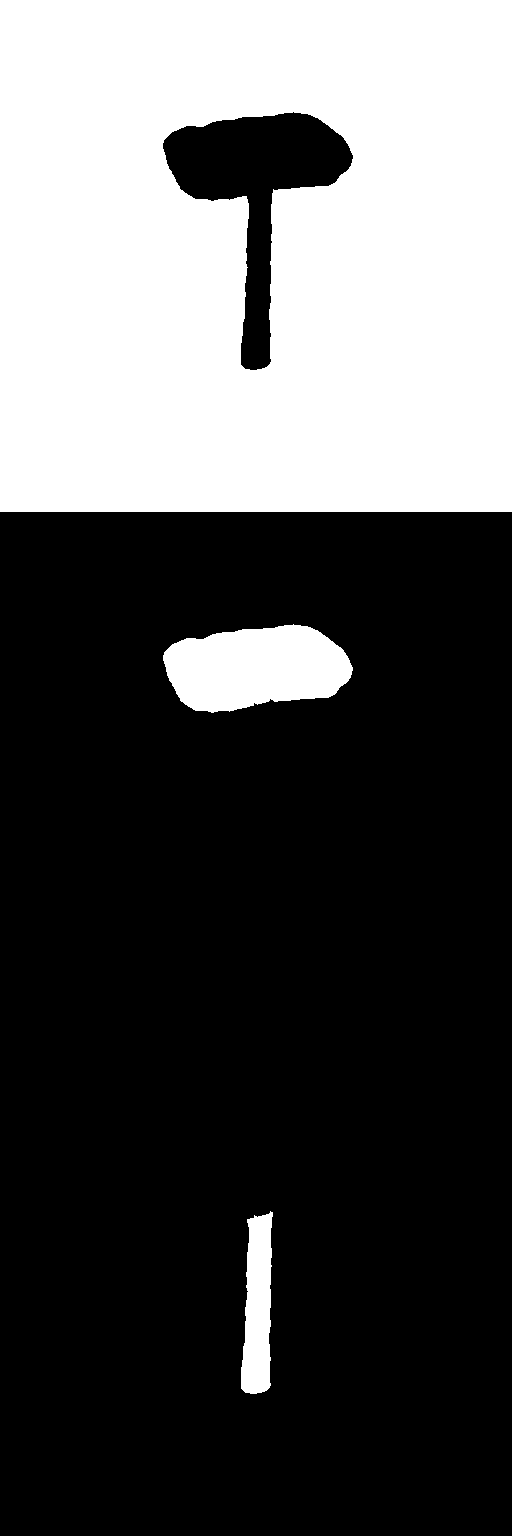

In [12]:
rast_dir = base_dir + 'validate/rast/'
rast = np.load(rast_dir + 'val_000055' + '_rast.npy')
mask0 = np.zeros_like(rast).astype(bool)
mask1 = np.zeros_like(rast).astype(bool)
mask2 = np.zeros_like(rast).astype(bool)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if(rast[i][j] > 0.5):
            mask1[i][j] = (mask_result[int(rast[i][j][0])-1] == 1)
            mask2[i][j] = (mask_result[int(rast[i][j][0])-1] == 2)
        else:
            mask0[i][j] = True

vis = visualize_mask(np.concatenate([mask0, mask1, mask2], axis=0))
vis

In [20]:
import torch
a = torch.tensor([1,2,3,4])
b = torch.tensor([5,5,2,3,0])
b[a].dtype

torch.int64